In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error

import pickle
import copy
import pandas as pd
import warnings

import dataset as dt
from xtx_model import simple_model, simple_cnn, simple_mlp, get_weight_grad, rate_size_fusion
from main import tf_score, score, model_score
import normlization as dt_norm

# 0

In [3]:
raw_data = dt.load_raw_data()

In [40]:
features, y = raw_data[:, :60], raw_data[:, 60]
ask_rate, ask_size, bid_rate, bid_size = features[:, :15], features[:, 15:30], features[:, 30:45], features[:, 45:60]
sign_y = np.sign(y)

In [92]:
pred_sign = np.copy(sign_y)
rand_sign = np.random.rand(len(sign_y))
rand_sign[rand_sign >= 0.25] = 1
rand_sign[rand_sign < 0.25] = -1

pred_sign = pred_sign * rand_sign
pred_sign[pred_sign == 0] = 1

score(y, pred_sign*0.5)

0.02246941289320148

In [93]:
"""we need the accuracy of trend prediction has 76% at least! """

'we need the accuracy of trend prediction has 76% at least! '

## sample balance

In [111]:
window_size = 120
time_step = 120
normed_data = dt_norm.slide_norm(features, window_size=window_size)
tx, ty = dt.data_sliding(normed_data, y, time_step=time_step)

In [113]:
nonzero_tx = np.copy(tx[ty != 0])
nonzero_ty = np.copy(ty[ty != 0])

In [117]:
nonzero_ty = np.copy(ty[ty != 0])
nonzero_sign_ty = np.sign(nonzero_ty)
nonzero_sign_ty[nonzero_sign_ty == -1] = 0

In [131]:
trains, vals, tests = dt.split_data([nonzero_tx, nonzero_sign_ty, np.abs(nonzero_ty)], split=[0.7, 0.1, 0.2], sampling=5)

train:331307, val:47329, test:94660


In [161]:
reg = False
mlp_model = simple_mlp(time_step=120, regression=reg)
loss = 'categorical_crossentropy' if not reg else tf_score
mlp_model.compile(Adam(2e-4), loss=loss, metrics=['accuracy'])

In [162]:
mlp_model.fit(trains[0], to_categorical(trains[1]),
              batch_size=256, epochs=20, 
              validation_data=(vals[0], to_categorical(vals[1])))

Train on 331307 samples, validate on 47329 samples
Epoch 1/20
331307/331307 [==============================] - 32s 98us/step - loss: 0.9063 - acc: 0.5024 - val_loss: 0.6938 - val_acc: 0.5051
Epoch 2/20
331307/331307 [==============================] - 30s 91us/step - loss: 0.7125 - acc: 0.5015 - val_loss: 0.6929 - val_acc: 0.5059
Epoch 3/20
331307/331307 [==============================] - 30s 91us/step - loss: 0.6970 - acc: 0.5057 - val_loss: 0.6927 - val_acc: 0.5105
Epoch 4/20
331307/331307 [==============================] - 30s 91us/step - loss: 0.6941 - acc: 0.5108 - val_loss: 0.6921 - val_acc: 0.5225
Epoch 5/20
331307/331307 [==============================] - 30s 91us/step - loss: 0.6931 - acc: 0.5162 - val_loss: 0.6922 - val_acc: 0.5118
Epoch 6/20
331307/331307 [==============================] - 30s 91us/step - loss: 0.6918 - acc: 0.5242 - val_loss: 0.6902 - val_acc: 0.5280
Epoch 7/20
331307/331307 [==============================] - 30s 91us/step - loss: 0.6904 - acc: 0.5321 - val_

In [168]:
reg = False
rnn_model = simple_model(time_step=120, regression=reg)
loss = 'categorical_crossentropy' if not reg else tf_score
rnn_model.compile(Adam(2e-4), loss=loss, metrics=['accuracy'])

In [167]:
rnn_model.fit(trains[0], to_categorical(trains[1]), batch_size=256, epochs=20, 
              validation_data=(vals[0], to_categorical(vals[1])))

Train on 331307 samples, validate on 47329 samples
Epoch 1/20
331307/331307 [==============================] - 408s 1ms/step - loss: 0.9121 - acc: 0.5403 - val_loss: 0.7380 - val_acc: 0.5681
Epoch 2/20
331307/331307 [==============================] - 407s 1ms/step - loss: 0.7118 - acc: 0.5531 - val_loss: 0.6927 - val_acc: 0.5655
Epoch 3/20
331307/331307 [==============================] - 406s 1ms/step - loss: 0.6923 - acc: 0.5555 - val_loss: 0.6852 - val_acc: 0.5716
Epoch 4/20
331307/331307 [==============================] - 408s 1ms/step - loss: 0.6884 - acc: 0.5576 - val_loss: 0.6834 - val_acc: 0.5693
Epoch 5/20
331307/331307 [==============================] - 408s 1ms/step - loss: 0.6870 - acc: 0.5580 - val_loss: 0.6831 - val_acc: 0.5697
Epoch 6/20
331307/331307 [==============================] - 412s 1ms/step - loss: 0.6864 - acc: 0.5577 - val_loss: 0.6804 - val_acc: 0.5747
Epoch 7/20
331307/331307 [==============================] - 412s 1ms/step - loss: 0.6859 - acc: 0.5582 - val_

KeyboardInterrupt: 

In [169]:
rnn_model.fit(trains[0], to_categorical(trains[1]), batch_size=256, epochs=20, 
              validation_data=(vals[0], to_categorical(vals[1])))

Train on 331307 samples, validate on 47329 samples
Epoch 1/20
331307/331307 [==============================] - 435s 1ms/step - loss: 0.9719 - acc: 0.5443 - val_loss: 0.7194 - val_acc: 0.5611
Epoch 2/20
331307/331307 [==============================] - 431s 1ms/step - loss: 0.7012 - acc: 0.5554 - val_loss: 0.6857 - val_acc: 0.5740
Epoch 3/20
331307/331307 [==============================] - 430s 1ms/step - loss: 0.6898 - acc: 0.5564 - val_loss: 0.6833 - val_acc: 0.5714
Epoch 4/20
331307/331307 [==============================] - 430s 1ms/step - loss: 0.6874 - acc: 0.5581 - val_loss: 0.6818 - val_acc: 0.5714
Epoch 5/20
331307/331307 [==============================] - 430s 1ms/step - loss: 0.6863 - acc: 0.5578 - val_loss: 0.6846 - val_acc: 0.5620
Epoch 6/20
331307/331307 [==============================] - 430s 1ms/step - loss: 0.6858 - acc: 0.5590 - val_loss: 0.6824 - val_acc: 0.5678
Epoch 7/20
331307/331307 [==============================] - 430s 1ms/step - loss: 0.6855 - acc: 0.5602 - val_

In [170]:
pred_train_y = rnn_model.predict(tests[0], batch_size=256, verbose=1)

94660/94660 [==============================] - 50s 533us/step


In [181]:
pred = np.argmax(pred_train_y, axis=1)
pred[pred == 0] = -1

In [182]:
test_y = np.copy(tests[2])
test_y_sign = np.copy(tests[1])
test_y_sign[test_y_sign == 0] = -1

In [185]:
score(test_y_sign*test_y, pred*0.5)

-0.4116618945194397

## 1

In [ ]:
time_step = 60
(train_x, train_y), (val_x, val_y), (test_x, test_y) = dt.dataset_slide_norm(time_step=time_step, norm_window_size=60)

In [ ]:
def rates_sizes_split(x):
    nb = x.shape[0]
    rates = np.concatenate([x[..., 0:15], x[..., 30:45]], axis=2)
    sizes = np.concatenate([x[..., 15:30], x[..., 45:60]], axis=2)
    
    return [rates, sizes]

In [ ]:
sign_model = rate_size_fusion(time_step=time_step)
sign_model.compile(Adam(2e-4), loss='binary_crossentropy', metrics=['accuracy'])
train_sign_y = np.sign(train_y+1e-3)
train_sign_y[train_sign_y==-1] = 0
val_sign_y = np.sign(val_y+1e-3)
val_sign_y[val_sign_y==-1] = 0
history = sign_model.fit(rates_sizes_split(train_x), train_sign_y, 
                    batch_size=512, epochs=20, 
                    validation_data=(rates_sizes_split(val_x), val_sign_y), 
                    callbacks=None)

In [ ]:
train_pred_sign = sign_model.predict(rates_sizes_split(train_x), batch_size=512, verbose=1)
np.sum(np.sign(train_pred_sign[:, 0]) == np.sign(train_y+1e-3)) / len(train_y)

In [ ]:
pred_sign = np.sign(train_pred_sign[:, 0])

In [ ]:
train_sign = np.sign(train_y)

In [ ]:
print('label 1: {}'.format(np.sum(train_sign == 1)))
a = np.sum(pred_sign[train_sign == 1] == 1)
b = np.sum(pred_sign[train_sign == 1] == -1)
print('prediction 1:{}, -1:{}:'.format(a, b))

In [ ]:
print('label -1: {}'.format(np.sum(train_sign == -1)))
a = np.sum(pred_sign[train_sign == -1] == 1)
b = np.sum(pred_sign[train_sign == -1] == -1)
print('prediction 1:{}, -1:{}:'.format(a, b))

In [ ]:
print('label 0: {}'.format(np.sum(train_sign == 0)))
a = np.sum(pred_sign[train_sign == 0] == 1)
b = np.sum(pred_sign[train_sign == 0] == -1)
print('prediction 1:{}, -1:{}:'.format(a, b))

# 2

In [112]:
def evaluate_precision(y, pred_sign):
    y_sign = np.sign(y)
    nb_valid = np.sum(y_sign != 0)
#     print('valid:', nb_valid)
    nb_zero = np.sum(y_sign == 0)
#     print('zero:', nb_zero)
    tp = np.sum(pred_sign[y_sign==1] == 1) + np.sum(pred_sign[y_sign==-1] == -1)
#     print('tp:', tp)
    return (tp+nb_zero) / (nb_valid+nb_zero)

In [12]:
diff_sign = np.sign(np.diff(features[:, 0]))

In [35]:
pred_sign = np.ones(len(y)) * -1
delay = 11
for i in range(delay, len(pred_sign)):
    pred_sign[i] = -diff_sign[i - delay] if diff_sign[i-delay] != 0 else pred_sign[i-1]

In [36]:
evaluate_precision(y, pred_sign)

0.49804633773363344

In [44]:
s0 = 1000
s1 = s0 + 100
diff_sign[s0-10:s1]

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  0.,  0.,
        0., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [45]:
pred_sign[s0:s1]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1.,
       -1., -1.,  1.,  1.,  1., -1., -1., -1., -1.])

In [46]:
sign_y[s0:s1]

array([ 0., -1., -1., -1., -1., -1.,  0.,  0.,  0., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1.,  0.,  0., -1., -1., -1.,
        0.,  0.,  0.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,
        0.,  0., -1., -1., -1., -1., -1.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [50]:
evaluate_precision(sign_y[:200], pred_sign[:200])

0.8092485549132948

## 3.

In [11]:
mean_rate = (np.mean(features[:, :15], axis=1) + np.mean(features[:,30:45], axis=1)) / 2

In [24]:
vacent_index = list(np.nonzero((features[:, :15] == 0).any(axis=1))[0])
for index in vacent_index:
    mean_rate[index] = (np.sum(features[index, :15]) + np.sum(features[index, 30:45])) / (np.sum(features[index, :15] != 0) + 15)

In [106]:
mean_rate_sign = np.sign(-np.diff(mean_rate))
evaluate_precision(sign_y[1:], -mean_rate_sign)

valid: 2366580
zero: 633418
tp: 114878


0.24943216628811085

In [ ]:
precisions = []
for i in range(5, 240, 3):
    ema_mean_rate = dt.ema(mean_rate[:100000], i)
    sign_ema = np.ones_like(ema_mean_rate)
    sign_ema[mean_rate[:100000] > ema_mean_rate] = -1
    precision = evaluate_precision(sign_y[1:100000], np.sign(np.diff(ema_mean_rate)))
    print(i, ':', precision)
    precisions.append(precision)

In [116]:
ema_mean_rate = dt.ema(mean_rate, 240)
sign_ema = np.ones_like(ema_mean_rate)
sign_ema[mean_rate > ema_mean_rate] = -1

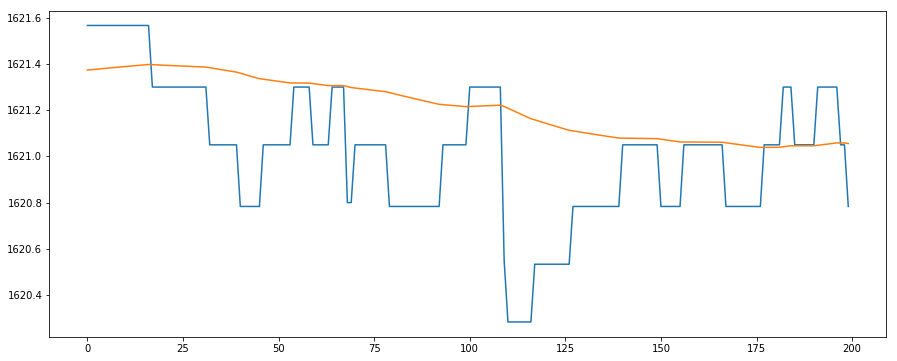

In [119]:
s0, s1 = 5000, 5200
plt.plot(mean_rate[s0:s1])
plt.plot(ema_mean_rate[s0:s1])
plt.show()

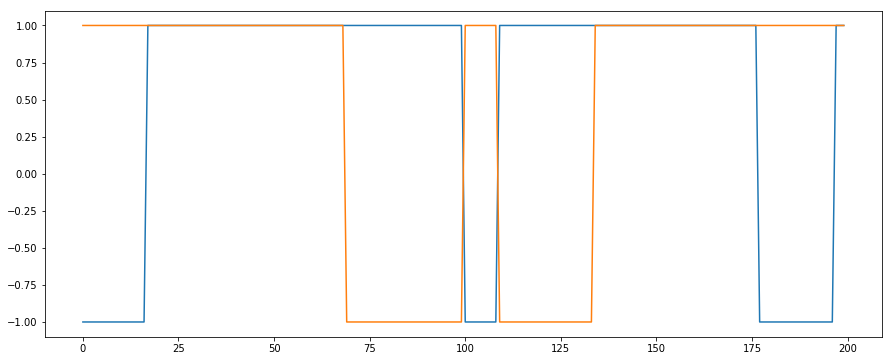

In [121]:
plt.rcParams['figure.figsize'] = (15.0, 6.0)
plt.plot(np.arange(s1-s0), sign_ema[s0:s1])
plt.plot(np.arange(s1-s0), -nozero_sign_y[s0:s1])
plt.show()

In [104]:
# evaluate_precision(sign_y[5000:5100], sign_ema[5000:5100])
evaluate_precision(sign_y, sign_ema)

valid: 2366581
zero: 633418
tp: 1204317


0.6125785375261792

In [84]:
np.sum(np.diff(nozero_sign_y)!=0)

44391

In [85]:
np.sum(np.diff(np.sign(np.diff(ema_mean_rate)))!=0)

91621

## 4.

In [136]:
ema_sign_y = dt.ema(sign_y, 5)

In [139]:
ema_sign_y[50:100]

array([-0.9996241 , -0.99974936, -0.9998329 , -0.6665553 , -0.7777035 ,
       -0.85180235, -0.56786823, -0.04524549, -0.363497  , -0.24233133,
       -0.16155422,  0.22563052, -0.18291299, -0.45527533, -0.63685024,
       -0.7579002 , -0.17193346,  0.21871103,  0.4791407 ,  0.65276045,
        0.76850694,  0.8456713 ,  0.8971142 ,  0.9314095 ,  0.954273  ,
        0.9695153 ,  0.9796769 ,  0.98645127,  0.9909675 ,  0.9939783 ,
        0.99598557,  0.9973237 ,  0.9982158 ,  0.9988105 ,  0.999207  ,
        0.99947137,  0.99964756,  0.6664317 ,  0.4442878 ,  0.29619187,
        0.19746125,  0.13164084,  0.08776056,  0.05850704,  0.03900469,
       -0.3073302 , -0.5382201 , -0.6921467 , -0.79476446, -0.8631763 ],
      dtype=float32)

In [137]:
evaluate_precision(nozero_sign_y, np.sign(ema_y))

0.992921330973777